### Image Captioning

In `NMT` Nueral Matchine Translation the we have two models, the `encoder` and the `decoder` models. The encoder encodes source text into a "thought-vector". The reason of this is to make the model understands the source sentence being translated.



In this tutorial we are going to relace the `encoder` with an image `recognition` model. We are going to use Transfare learning and Fine tunning to recognizes what the image contains and output the vector of numbers so called the "thougth vector" or summary vector into text.


### Flow chart

We are going to use `VGG16`  model to co image classification. But instead of using the classification layer we are going to take the second last dense layer as our "thought vector".

 We will use this vector as the initial state of the Gated Recurrent Units (GRU). However, the internal state-size of the GRU is only 512, so we need an intermediate fully-connected (dense) layer to map the vector with 4096 elements down to a vector with only 512 elements.

 The decoder then uses this initial-state together with a start-marker "sos" to begin producing output words. In the first iteration it will hopefully output the word "big". Then we input this word into the decoder and hopefully we get the word "brown" out, and so on. Finally we have generated the text "big brown bear sitting sos" where "eos" marks the end of the text.


![img](https://github.com/Hvass-Labs/TensorFlow-Tutorials/raw/d5f33973570fe6ef9c78c8a38c7449a932c81010/images/22_image_captioning_flowchart.png)



### Basic image captioning flow in this notebook.

1. Use ``VGG16`` model to classify images
2. Trim out the last layer of the VGG16 models and take the fully conected outputs from the second last of the image classification model.
3. Use the output of the second last fully connected dense layer as the initial state of the GRU in the `Decoder`.

### Imports

In [2]:
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np

import os, time, sys
from PIL import Image

from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras.applications import VGG16

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tf.__version__

'2.6.0'

### Mounting the drive

We are going to load the data and their annotations from google drive. So we need to mount the drive.



In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
base_path = "/content/drive/My Drive/image-captioning/coco"
os.listdir(base_path)

['annotations_trainval2017.zip', 'val2017.zip', 'data_urls.txt']

### Extracting zip files


In [6]:
import zipfile

# annotations
with zipfile.ZipFile(os.path.join(base_path, 'annotations_trainval2017.zip'), "r") as z:
  z.extractall(base_path)

# annotations
with zipfile.ZipFile(os.path.join(base_path, 'val2017.zip'), "r") as z:
  z.extractall(base_path)

print("Done")

Done


In [7]:
import json

In [57]:
def load_records():
  path = os.path.join(base_path, 
                      "annotations", "captions_val2017.json")
  
  with open(path, "r", encoding="utf-8") as file:
        data_raw = json.load(file)

  images = data_raw['images']
  annotations = data_raw['annotations']

  records = dict()
  for image in images:
    
    record = dict()
    record["filename"] = image["file_name"]
    record["id"] = image["id"]

    record["captions"] = list()

    records[image["id"]] = record

  for annotation in annotations:
    record = records[annotation['image_id']]
    record['captions'].append(annotation.get("caption"))

  records_list = [(key, record['filename'], record['captions'])
                    for key, record in sorted(records.items())]
  ids, filenames, captions = zip(*records_list)
  return ids, filenames, captions

ids, filenames, captions = load_records()

In [61]:
filenames[:2], ids[:2], captions[:2]

(('000000000139.jpg', '000000000285.jpg'),
 (139, 285),
 (['A woman stands in the dining area at the table.',
   'A room with chairs, a table, and a woman in it.',
   'A woman standing in a kitchen by a window',
   'A person standing at a table in a room.',
   'A living area with a television and a table'],
  ['A big burly grizzly bear is show with grass in the background.',
   'The large brown bear has a black nose.',
   'Closeup of a brown bear sitting in a grassy area.',
   'A large bear that is sitting on grass. ',
   "A close up picture of a brown bear's face."]))

### Getting image names and captions

In [62]:
_, image_names, captions = load_records()

### Counting examples

We are then going to count how many examples do we have in our dataset.

In [63]:
num_images = len(image_names)
num_images

5000

As you can see we only have `5000` images in this dataset, you can use the train set which contains a lot of training examples.

### Helper functions
We are then going to define helper functions that will help us to do the following:

1. loading images
2. displaying images

In [64]:
def load_image(path, size=None):
  image = Image.open(path)
  if not size is  None:
    image = image.resize(size=size, resample=Image.LANCZOS)

  image = np.array(image, dtype=np.float32)
  image = image/255.0

  # gray scale image to a 3-dim RGB array
  if (len(image.shape) == 2):
    image = np.repeat(image[:, :, np.newaxis], 3, axis=2)
  return  image


In [65]:
def show_image(index):
  assert index < num_images - 1, f"recieved index {index} for index range [0, {num_images}]"

  # path to images 
  img_dirs = os.path.join(base_path, "val2017")
  file_name = image_names[index]
  caps = captions[index]

  for caption in caps:
    print(caption)

  image = load_image(os.path.join(img_dirs, file_name))
  plt.imshow(image)
  plt.show()

A beautiful woman taking a picture with her smart phone.
People underneath an arched bridge near the water.
A girl is taking a picture of people fishing.
The woman is taking a photo of the white goose next to the river.
A waterway under a bridge with people sitting down and a woman taking a photo.


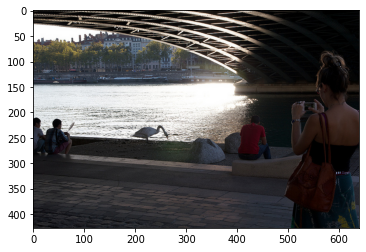

In [66]:
show_image(10)

A woman stands in the dining area at the table.
A room with chairs, a table, and a woman in it.
A woman standing in a kitchen by a window
A person standing at a table in a room.
A living area with a television and a table


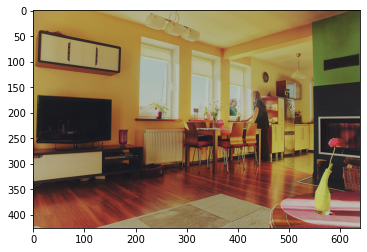

In [67]:
show_image(0)

An adult elephant is pictured walking with a baby elephant.
A baby elephant walks with an older elephant
A baby elephant walks between the legs of its mother.
A baby elephant walking along the same path as its mother. 
a bunch of elephants are standing together in a pin


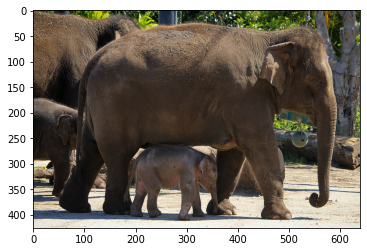

In [68]:
show_image(500)

### The VGG16

We are going to use transfare learnig (fine tunning) to us the VGG16 model to perform image classification.

> If ``include_top=True`` then the whole VGG16 model is downloaded which is about 528 MB. If ``include_top=False`` then only the convolutional part of the VGG16 model is downloaded which is just 57 MB.

We are going to download the whole model.

In [ ]:
image_model = VGG16(include_top=True, weights='imagenet')

### Model summary

In [70]:
image_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

We are going to use all the layers of the models up from the top up to `fc2` layer. we are not interested in the `prediction` layer.

In [71]:
transfare_layer = image_model.get_layer("fc2")
transfare_layer

We called it the "transfer-layer" because we will transfer its output to another model that creates the image captions.

To do this, first we need to create a new model which has the same input as the original ``VGG16`` model but outputs the transfer-values from the fc2 layer.

In [72]:
image_model_transfare = keras.Model(
  inputs=image_model.input, outputs = transfare_layer.output,
  name= "image_model_transfare" 
)
image_model_transfare.summary()

Model: "image_model_transfare"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 1

### Getting the size of the image

We are now going to ge the shape of the image, that `VGG16` accept.


In [74]:
image_size = K.int_shape(image_model.input)[1:3]
image_size

(224, 224)

For each input image, the new model will output a vector of transfer-values with the following length.

In [76]:
transfer_values_size = K.int_shape(transfare_layer.output)[1]
transfer_values_size

4096

### Image processing

1. helper function for printing the progress.

In [77]:
def print_progress(count, max_count):
  pct_complete = count / max_count
  msg = "\r- Progress: {0:.1%}".format(pct_complete)
  sys.stdout.write(msg)
  sys.stdout.flush()

This is the function for processing the given files using the VGG16-model and returning their transfer-values.

In [ ]:
def process_images(data_dir, filenames, batch_size=32):
    """
    Process all the given files in the given data_dir using the
    pre-trained image-model and return their transfer-values.
    
    Note that we process the images in batches to save
    memory and improve efficiency on the GPU.
    """
    
    # Number of images to process.
    num_images = len(filenames)

    # Pre-allocate input-batch-array for images.
    shape = (batch_size,) + img_size + (3,)
    image_batch = np.zeros(shape=shape, dtype=np.float16)

    # Pre-allocate output-array for transfer-values.
    # Note that we use 16-bit floating-points to save memory.
    shape = (num_images, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    # Initialize index into the filenames.
    start_index = 0

    # Process batches of image-files.
    while start_index < num_images:
        # Print the percentage-progress.
        print_progress(count=start_index, max_count=num_images)

        # End-index for this batch.
        end_index = start_index + batch_size

        # Ensure end-index is within bounds.
        if end_index > num_images:
            end_index = num_images

        # The last batch may have a different batch-size.
        current_batch_size = end_index - start_index

        # Load all the images in the batch.
        for i, filename in enumerate(filenames[start_index:end_index]):
            # Path for the image-file.
            path = os.path.join(data_dir, filename)

            # Load and resize the image.
            # This returns the image as a numpy-array.
            img = load_image(path, size=img_size)

            # Save the image for later use.
            image_batch[i] = img

        # Use the pre-trained image-model to process the image.
        # Note that the last batch may have a different size,
        # so we only use the relevant images.
        transfer_values_batch = \
            image_model_transfer.predict(image_batch[0:current_batch_size])

        # Save the transfer-values in the pre-allocated array.
        transfer_values[start_index:end_index] = \
            transfer_values_batch[0:current_batch_size]

        # Increase the index for the next loop-iteration.
        start_index = end_index

    # Print newline.
    print()

    return transfer_values

### Tokenizer

Now we need to work with captions and tokenize them, so that each word in the caption will be represented by an integer token.

In [78]:
sos_token = "<sos> "
eos_token = " <eos>"

Now let's apped the `<sos>` and `<eos>` maker to our captions.

In [82]:
def mark_captions(captions_listlist):
    return [[sos_token + caption + eos_token
                        for caption in captions_list]
                        for captions_list in captions_listlist]

In [83]:
captions_train_marked = mark_captions(captions)
captions_train_marked[0]

['<sos> A woman stands in the dining area at the table. <eos>',
 '<sos> A room with chairs, a table, and a woman in it. <eos>',
 '<sos> A woman standing in a kitchen by a window <eos>',
 '<sos> A person standing at a table in a room. <eos>',
 '<sos> A living area with a television and a table <eos>']

### Flattening the captions

We need to flatten the caption so that we will be able to prepare our vocabulary using the tokenizer from keras. We aregoing to se the maximum number of word to 10000, so that the vocabulary will contains the top 10000 words in the caption corpus. All words that are not in the top 10000 will be converted to unknown.

In [84]:
def flatten(captions_listlist):
    return [caption
                     for captions_list in captions_listlist
                     for caption in captions_list]

In [85]:
captions_train_flat = flatten(captions_train_marked)

In [86]:
captions_train_flat[0]

'<sos> A woman stands in the dining area at the table. <eos>'

In [88]:
len(captions_train_flat), len(image_names)

(25014, 5000)

In [89]:
num_words = 10_000

In [91]:
class TokenizerWrap(Tokenizer):
  def __init__(self, texts, num_words=None):
    Tokenizer.__init__(self, num_words=num_words)
    self.fit_on_texts(texts)

    # Create inverse lookup from integer-tokens to words.
    self.index_to_word = dict(zip(self.word_index.values(),
                                      self.word_index.keys()))
  def token_to_word(self, token):
    """Lookup a single word from an integer-token."""

    word = " " if token == 0 else self.index_to_word[token]
    return word 
  def tokens_to_string(self, tokens):
      """Convert a list of integer-tokens to a string."""

      # Create a list of the individual words.
      words = [self.index_to_word[token]
                for token in tokens
                if token != 0]
      
      # Concatenate the words to a single string
      # with space between all the words.
      return " ".join(words)

  def captions_to_tokens(self, captions_listlist):
        """
        Convert a list-of-list with text-captions to
        a list-of-list of integer-tokens.
        """
        # Note that text_to_sequences() takes a list of texts.
        tokens = [self.texts_to_sequences(captions_list)
                  for captions_list in captions_listlist]
        
        return tokens

Now we can create the tokenizer using the `flattened` captions.

In [93]:
tokenizer = TokenizerWrap(texts=captions_train_flat,
                          num_words=num_words)

### Getting the start and the end tokens

In [96]:
token_start = tokenizer.word_index["sos"]
token_start

2

In [97]:
token_start = tokenizer.word_index["eos"]
token_start

3

### All captions to integers

In [98]:
tokens_train = tokenizer.captions_to_tokens(captions_train_marked)
tokens_train[:2]

[[[2, 1, 22, 171, 7, 6, 444, 106, 18, 6, 24, 3],
  [2, 1, 45, 8, 295, 1, 24, 9, 1, 22, 7, 27, 3],
  [2, 1, 22, 16, 7, 1, 68, 50, 1, 132, 3],
  [2, 1, 30, 16, 18, 1, 24, 7, 1, 45, 3],
  [2, 1, 119, 106, 8, 1, 288, 9, 1, 24, 3]],
 [[2, 1, 166, 4305, 1898, 99, 10, 676, 8, 66, 7, 6, 153, 3],
  [2, 6, 28, 110, 99, 49, 1, 40, 1193, 3],
  [2, 799, 5, 1, 110, 99, 13, 7, 1, 202, 106, 3],
  [2, 1, 28, 99, 25, 10, 13, 4, 66, 3],
  [2, 1, 135, 34, 85, 5, 1, 110, 3269, 299, 3]]]

the following are their corresponding words

In [99]:
captions_train_marked[0]

['<sos> A woman stands in the dining area at the table. <eos>',
 '<sos> A room with chairs, a table, and a woman in it. <eos>',
 '<sos> A woman standing in a kitchen by a window <eos>',
 '<sos> A person standing at a table in a room. <eos>',
 '<sos> A living area with a television and a table <eos>']

### Data generator

Each image in the the train set has at least 5 captions. describing the contents of an image. The Nueral Net will be trained in batches of transfer-values for the images and sequences of integer-tokens for the captions. If we were to have matching numpy arrays for the training-set, we would either have to only use a single caption for each image and ignore the rest of this valuable data, or we would have to repeat the image transfer-values for each of the captions, which would waste a lot of memory.

A better solution is to create a custom data-generator for Keras that will create a batch of data with randomly selected transfer-values and token-sequences.

This helper-function returns a list of random token-sequences for the images with the given indices in the training-set.


In [100]:
def get_random_caption_tokens(idx):
    """
    Given a list of indices for images in the training-set,
    select a token-sequence for a random caption,
    and return a list of all these token-sequences.
    """
    
    # Initialize an empty list for the results.
    result = []

    # For each of the indices.
    for i in idx:
        # The index i points to an image in the training-set.
        # Each image in the training-set has at least 5 captions
        # which have been converted to tokens in tokens_train.
        # We want to select one of these token-sequences at random.

        # Get a random index for a token-sequence.
        j = np.random.choice(len(tokens_train[i]))

        # Get the j'th token-sequence for image i.
        tokens = tokens_train[i][j]

        # Add this token-sequence to the list of results.
        result.append(tokens)

    return result

### Credits

* [Hvass-Labs](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/22_Image_Captioning.ipynb)